## **Flow Matching** 

This notebook trains a simple (vanilla) flow matching model on the CIFAR-10 dataset. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
class FlowUNet(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels + 1, base_channels, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        self.middle = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 4, base_channels * 4, 3, padding=1), nn.ReLU()
        )
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels * 2, base_channels * 2, 3, padding=1), nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base_channels, base_channels, 3, padding=1), nn.ReLU()
        )
        self.out = nn.Sequential(
            nn.Conv2d(base_channels, in_channels, 1),
            nn.Tanh()  # restricts output to [-1, 1]
        )

    def forward(self, x, t):
        t = t[:, None, None, None].float().expand(-1, 1, x.size(2), x.size(3))
        x = torch.cat([x, t], dim=1)
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        m = self.middle(self.pool2(e2))
        d1 = self.up1(m)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.out(d2)


In [3]:
def sample_flow_data(x0):
    B = x0.size(0)
    x1 = torch.randn_like(x0)
    eps = 1e-3
    t = torch.rand(B, device=x0.device).clamp(eps, 1 - eps).view(B, 1, 1, 1)
    xt = (1 - t) * x0 + t * x1

    #scale = 10.0
    #v_target = (x1 - x0) / (t * (1 - t)) / scale
    
    v_target = (x1 - x0) / (t * (1 - t))
    return xt, t.squeeze(), v_target

In [4]:
def train_flow_matching(model, loader, optimizer, epochs=10, device='cuda'):
    model.train()
    all_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in tqdm(loader, desc=f"Epoch {epoch+1}"):
            x = x.to(device)
            xt, t, v_target = sample_flow_data(x)
            pred_v = model(xt, t)
            loss = F.smooth_l1_loss(pred_v, v_target, beta=1.0)
            #loss = F.mse_loss(pred_v, v_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(loader.dataset)
        all_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}")
    return all_losses

In [5]:
@torch.no_grad()
def sample_flow(model, steps=50, return_trajectory=False):
    model.eval()
    x = torch.randn(1, 3, 32, 32).to(next(model.parameters()).device)
    dt = 1.0 / steps
    trajectory = [x.clone().cpu()]
    for i in range(steps):
        t = torch.ones(x.size(0), device=x.device) * (1 - i / steps)
        v = model(x, t)
        x = x - v * dt
        if return_trajectory:
            trajectory.append(x.clone().cpu())
    return x.clamp(-1, 1).cpu(), trajectory if return_trajectory else None

Epoch 1: 100%|██████████| 391/391 [00:09<00:00, 42.54it/s]


Epoch 1: loss = 13.1817


Epoch 2: 100%|██████████| 391/391 [00:08<00:00, 45.16it/s]


Epoch 2: loss = 13.2290


Epoch 3: 100%|██████████| 391/391 [00:08<00:00, 45.60it/s]


Epoch 3: loss = 13.1728


Epoch 4: 100%|██████████| 391/391 [00:08<00:00, 45.63it/s]


Epoch 4: loss = 13.1923


Epoch 5: 100%|██████████| 391/391 [00:08<00:00, 47.63it/s]


Epoch 5: loss = 12.8710


Epoch 6: 100%|██████████| 391/391 [00:08<00:00, 46.19it/s]


Epoch 6: loss = 12.8471


Epoch 7: 100%|██████████| 391/391 [00:07<00:00, 52.05it/s]


Epoch 7: loss = 12.8933


Epoch 8: 100%|██████████| 391/391 [00:08<00:00, 48.57it/s]


Epoch 8: loss = 12.5317


Epoch 9: 100%|██████████| 391/391 [00:08<00:00, 48.11it/s]


Epoch 9: loss = 12.8404


Epoch 10: 100%|██████████| 391/391 [00:07<00:00, 52.81it/s]


Epoch 10: loss = 12.7896


Epoch 11: 100%|██████████| 391/391 [00:07<00:00, 53.63it/s]


Epoch 11: loss = 12.8078


Epoch 12: 100%|██████████| 391/391 [00:08<00:00, 45.81it/s]


Epoch 12: loss = 13.1031


Epoch 13: 100%|██████████| 391/391 [00:07<00:00, 49.34it/s]


Epoch 13: loss = 12.5311


Epoch 14: 100%|██████████| 391/391 [00:07<00:00, 49.47it/s]


Epoch 14: loss = 12.7374


Epoch 15: 100%|██████████| 391/391 [00:08<00:00, 47.88it/s]


Epoch 15: loss = 13.3254


Epoch 16: 100%|██████████| 391/391 [00:08<00:00, 48.31it/s]


Epoch 16: loss = 12.9351


Epoch 17: 100%|██████████| 391/391 [00:07<00:00, 53.54it/s]


Epoch 17: loss = 12.7672


Epoch 18: 100%|██████████| 391/391 [00:08<00:00, 45.75it/s]


Epoch 18: loss = 12.4913


Epoch 19: 100%|██████████| 391/391 [00:07<00:00, 49.51it/s]


Epoch 19: loss = 13.3484


Epoch 20: 100%|██████████| 391/391 [00:08<00:00, 45.65it/s]


Epoch 20: loss = 12.9516


Epoch 21: 100%|██████████| 391/391 [00:07<00:00, 49.86it/s]


Epoch 21: loss = 12.9257


Epoch 22: 100%|██████████| 391/391 [00:08<00:00, 45.02it/s]


Epoch 22: loss = 13.1464


Epoch 23: 100%|██████████| 391/391 [00:07<00:00, 52.30it/s]


Epoch 23: loss = 12.4985


Epoch 24: 100%|██████████| 391/391 [00:08<00:00, 44.10it/s]


Epoch 24: loss = 12.5804


Epoch 25: 100%|██████████| 391/391 [00:07<00:00, 49.38it/s]


Epoch 25: loss = 12.5576


Epoch 26: 100%|██████████| 391/391 [00:08<00:00, 46.78it/s]


Epoch 26: loss = 13.1643


Epoch 27: 100%|██████████| 391/391 [00:07<00:00, 54.52it/s]


Epoch 27: loss = 12.3523


Epoch 28: 100%|██████████| 391/391 [00:07<00:00, 51.94it/s]


Epoch 28: loss = 12.4902


Epoch 29: 100%|██████████| 391/391 [00:07<00:00, 53.63it/s]


Epoch 29: loss = 12.5720


Epoch 30: 100%|██████████| 391/391 [00:07<00:00, 54.20it/s]


Epoch 30: loss = 13.2137


Epoch 31: 100%|██████████| 391/391 [00:07<00:00, 53.41it/s]


Epoch 31: loss = 13.2943


Epoch 32: 100%|██████████| 391/391 [00:07<00:00, 52.20it/s]


Epoch 32: loss = 13.0120


Epoch 33: 100%|██████████| 391/391 [00:08<00:00, 45.61it/s]


Epoch 33: loss = 13.1594


Epoch 34: 100%|██████████| 391/391 [00:08<00:00, 48.67it/s]


Epoch 34: loss = 13.1813


Epoch 35: 100%|██████████| 391/391 [00:08<00:00, 46.86it/s]


Epoch 35: loss = 13.2373


Epoch 36: 100%|██████████| 391/391 [00:07<00:00, 52.37it/s]


Epoch 36: loss = 13.0523


Epoch 37: 100%|██████████| 391/391 [00:07<00:00, 49.44it/s]


Epoch 37: loss = 13.1236


Epoch 38: 100%|██████████| 391/391 [00:08<00:00, 47.07it/s]


Epoch 38: loss = 12.7218


Epoch 39: 100%|██████████| 391/391 [00:07<00:00, 49.09it/s]


Epoch 39: loss = 12.5708


Epoch 40: 100%|██████████| 391/391 [00:08<00:00, 46.14it/s]


Epoch 40: loss = 13.0409


Epoch 41: 100%|██████████| 391/391 [00:08<00:00, 45.43it/s]


Epoch 41: loss = 13.4477


Epoch 42: 100%|██████████| 391/391 [00:08<00:00, 44.83it/s]


Epoch 42: loss = 12.7460


Epoch 43: 100%|██████████| 391/391 [00:08<00:00, 45.79it/s]


Epoch 43: loss = 13.1561


Epoch 44: 100%|██████████| 391/391 [00:08<00:00, 45.68it/s]


Epoch 44: loss = 12.8537


Epoch 45: 100%|██████████| 391/391 [00:07<00:00, 50.62it/s]


Epoch 45: loss = 13.2086


Epoch 46: 100%|██████████| 391/391 [00:08<00:00, 46.92it/s]


Epoch 46: loss = 12.6987


Epoch 47: 100%|██████████| 391/391 [00:08<00:00, 45.61it/s]


Epoch 47: loss = 13.5226


Epoch 48: 100%|██████████| 391/391 [00:08<00:00, 45.93it/s]


Epoch 48: loss = 13.1467


Epoch 49: 100%|██████████| 391/391 [00:07<00:00, 49.82it/s]


Epoch 49: loss = 13.1715


Epoch 50: 100%|██████████| 391/391 [00:07<00:00, 52.87it/s]

Epoch 50: loss = 12.7455


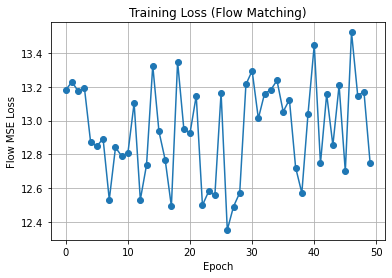

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2. - 1.)
])
dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = FlowUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

losses = train_flow_matching(model, loader, optimizer, epochs=50, device=device)

# Plot training loss
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Flow MSE Loss")
plt.title("Training Loss (Flow Matching)")
plt.grid(True)
plt.show()

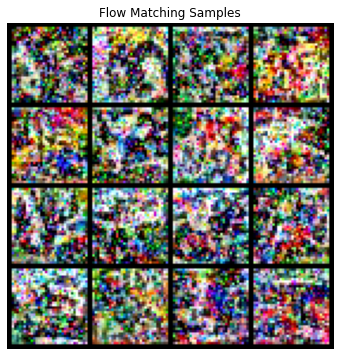

In [7]:
samples = []
model.eval()
for _ in range(16):
    sample, _ = sample_flow(model, steps=50)
    samples.append(sample[0])
samples = torch.stack(samples)
grid = make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Flow Matching Samples")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


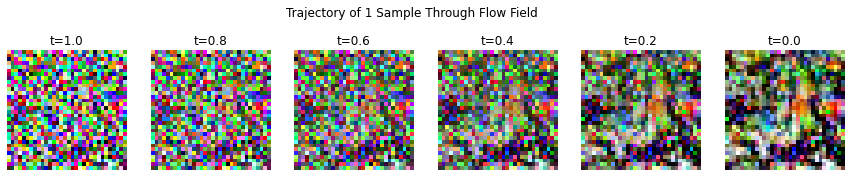

In [8]:
_, trajectory = sample_flow(model, steps=20, return_trajectory=True)
plt.figure(figsize=(15, 3))
for i, img in enumerate(trajectory[::4]):
    plt.subplot(1, len(trajectory[::4]), i + 1)
    plt.imshow((img[0].permute(1, 2, 0) + 1) / 2)
    plt.axis("off")
    plt.title(f"t={1 - i*0.2:.1f}")
plt.suptitle("Trajectory of 1 Sample Through Flow Field")
plt.show()